In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()

        # 2D Convolutional layer
        self.conv2d = nn.Conv2d(in_channels=4, out_channels=20, kernel_size=3, padding=1)

        # Average Pooling layer
        self.avg_pool = nn.AvgPool2d(kernel_size=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # LSTM layer
        self.lstm = nn.LSTM(input_size=20, hidden_size=25, batch_first=True)

        # Fully connected layer (Now predicting 4 variables)
        self.fc = nn.Linear(25, 4 * 96 * 144)

    def forward(self, x):
        # Vérifiez les dimensions de x
        if x.dim() != 5:
            raise ValueError(f"Expected input to have 5 dimensions, but got {x.dim()} dimensions instead.")

        batch_size, time_steps, height, width, channels = x.shape

        # Reshape to (batch_size * time_steps, channels, height, width) for CNN
        x = x.permute(0, 1, 4, 2, 3).contiguous().view(-1, channels, height, width)

        # Apply Conv2D
        x = F.relu(self.conv2d(x))

        # Apply Average Pooling
        x = self.avg_pool(x)

        # Apply Global Average Pooling (to shape: (batch_size * time_steps, channels, 1, 1))
        x = self.global_avg_pool(x)

        # Flatten to (batch_size * time_steps, channels)
        x = x.view(x.size(0), -1)

        # Reshape to (batch_size, time_steps, features) for LSTM
        x = x.view(batch_size, time_steps, -1)

        # LSTM
        x, _ = self.lstm(x)

        # Take the last time step's output
        x = x[:, -1, :]

        # Fully connected layer
        x = self.fc(x)

        # Reshape to (batch_size, 4, 96, 144) for 4 output variables
        x = x.view(batch_size, 4, 96, 144)

        return x


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, x_path, y_path):
        # Load .npy files
        self.x_data = np.load(x_path)  # Shape: (231, 10, 96, 144, 4)
        self.y_data = np.load(y_path)  # Shape: (231, 96, 144, 4)

        # Vérification des dimensions
        assert self.x_data.shape == (231, 10, 96, 144, 4), f"Unexpected shape for x_data: {self.x_data.shape}"
        assert self.y_data.shape == (231, 96, 144, 4), f"Unexpected shape for y_data: {self.y_data.shape}"

        # Convert to PyTorch tensors
        self.x_data = torch.tensor(self.x_data, dtype=torch.float32)  # Keep shape (231, 10, 96, 144, 4)
        self.y_data = torch.tensor(self.y_data, dtype=torch.float32)  # Change to (231, 4, 96, 144)

        # Reshape y to match model output (batch, 4, 96, 144)
        self.y_data = self.y_data.permute(0, 3, 1, 2)  # Move last dim (4) to second dim

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Paths to .npy files
x_train_path = "x_train_scaled.npy"
y_train_path = "y_train_scaled.npy"

# Create dataset and dataloader
dataset = CustomDataset(x_train_path, y_train_path)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # Adjust batch_size as needed



In [8]:
from torch.utils.data import random_split, DataLoader

# Charger le dataset complet
dataset = CustomDataset(x_train_path, y_train_path)

# Définir taille de validation
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

# Split en dataset entraînement / validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [10]:
# Initialisation modèle, device, optimizer, loss (comme tu l’as déjà fait)
model = CNNLSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Forward
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

    # Phase de validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # Sauvegarde du meilleur modèle
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("📌 Nouveau meilleur modèle sauvegardé.")


Epoch [1/50] | Train Loss: 1.031399 | Val Loss: 0.907987
📌 Nouveau meilleur modèle sauvegardé.
Epoch [2/50] | Train Loss: 1.005654 | Val Loss: 0.897428
📌 Nouveau meilleur modèle sauvegardé.
Epoch [3/50] | Train Loss: 0.998065 | Val Loss: 0.882984
📌 Nouveau meilleur modèle sauvegardé.
Epoch [4/50] | Train Loss: 0.974039 | Val Loss: 0.862240
📌 Nouveau meilleur modèle sauvegardé.
Epoch [5/50] | Train Loss: 0.946579 | Val Loss: 0.833475
📌 Nouveau meilleur modèle sauvegardé.
Epoch [6/50] | Train Loss: 0.901392 | Val Loss: 0.800690
📌 Nouveau meilleur modèle sauvegardé.
Epoch [7/50] | Train Loss: 0.861217 | Val Loss: 0.773870
📌 Nouveau meilleur modèle sauvegardé.
Epoch [8/50] | Train Loss: 0.832590 | Val Loss: 0.747891
📌 Nouveau meilleur modèle sauvegardé.
Epoch [9/50] | Train Loss: 0.784575 | Val Loss: 0.723914
📌 Nouveau meilleur modèle sauvegardé.
Epoch [10/50] | Train Loss: 0.771156 | Val Loss: 0.704572
📌 Nouveau meilleur modèle sauvegardé.
Epoch [11/50] | Train Loss: 0.747700 | Val Loss: 

In [15]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

# 1. Dataset pour le test
class TestDataset(Dataset):
    def __init__(self, x_path):
        self.x_data = np.load(x_path)  # (77, 10, 96, 144, 4)
        self.x_data = torch.tensor(self.x_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx]

# 2. Charger le dataset test
x_test_path = "x_test_scaled.npy"
test_dataset = TestDataset(x_test_path)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 3. Charger le modèle
model = CNNLSTM()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.to(device)
model.eval()

# 4. Faire la prédiction
all_predictions = []

with torch.no_grad():
    for batch_x in test_loader:
        batch_x = batch_x.to(device)  # (1, 10, 96, 144, 4)
        outputs = model(batch_x)      # (1, 4, 96, 144)
        all_predictions.append(outputs.cpu().numpy())

# 5. Fusionner les prédictions
all_predictions = np.concatenate(all_predictions, axis=0)  # (77, 4, 96, 144)

# Sauvegarder si besoin
np.save("y_test_predicted.npy", all_predictions)
print("✅ Prédictions sauvegardées sous 'y_test_predicted.npy'")


✅ Prédictions sauvegardées sous 'y_test_predicted.npy'


In [16]:
x_test = np.load("x_test_scaled.npy")
print(x_test.shape)

(77, 10, 96, 144, 4)


C:\Users\Nathanael\AppData\Local\Temp\ipykernel_20352\1315718862.py:40: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  plt.tight_layout()
C:\Users\Nathanael\AppData\Local\Temp\ipykernel_20352\1315718862.py:40: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()


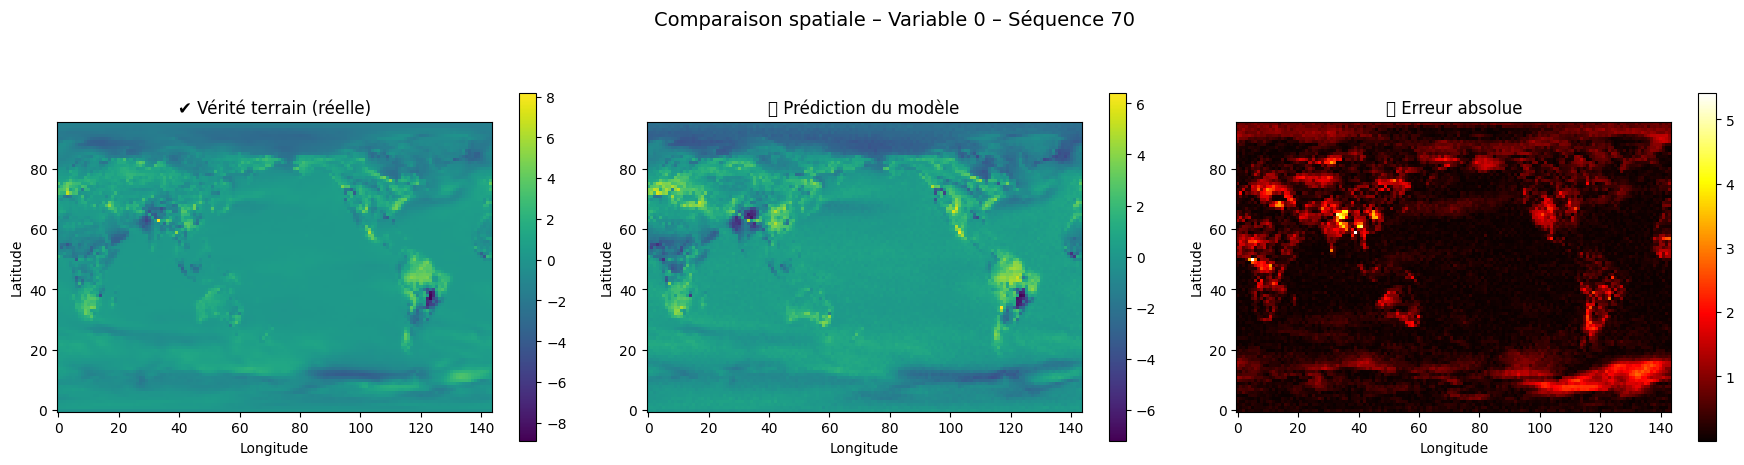

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Charger les fichiers
y_pred = np.load("y_test_predicted.npy")     # shape: (77, 4, 96, 144)
y_true = np.load("y_test_scaled.npy")        # shape: (77, 96, 144, 4)

# Transposer y_true pour correspondre à y_pred (de (samples, lat, lon, variables) → (samples, variables, lat, lon))
y_true = np.transpose(y_true, (0, 3, 1, 2))   # (77, 4, 96, 144)

# Choisir la séquence et la variable à comparer
sequence_index = 70     # séquence temporelle
variable_index = 0     # variable climatique

# Extraire les cartes
pred_map = y_pred[sequence_index, variable_index]
true_map = y_true[sequence_index, variable_index]
error_map = np.abs(pred_map - true_map)

# Affichage côte à côte
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im1 = axes[0].imshow(true_map, cmap='viridis', origin='lower')
axes[0].set_title("✔️ Vérité terrain (réelle)")
plt.colorbar(im1, ax=axes[0], shrink=0.8)

im2 = axes[1].imshow(pred_map, cmap='viridis', origin='lower')
axes[1].set_title("🔮 Prédiction du modèle")
plt.colorbar(im2, ax=axes[1], shrink=0.8)

im3 = axes[2].imshow(error_map, cmap='hot', origin='lower')
axes[2].set_title("❌ Erreur absolue")
plt.colorbar(im3, ax=axes[2], shrink=0.8)

for ax in axes:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

plt.suptitle(f"Comparaison spatiale – Variable {variable_index} – Séquence {sequence_index}", fontsize=14)
plt.tight_layout()
plt.show()
